In [1]:
"""
Module Name: examples.ipynb
Author:      Peter Meier
Email:       peter.meier@audiolabs-erlangen.de
Date:        2024-10-01
Version:     0.0.1 
Description: Jupyter Notebook with Example Plots Using Real-Time PLP.
License:     MIT License (https://opensource.org/licenses/MIT)
"""

import librosa
from realtimeplp import RealTimeBeatTracker, BeatAnalyzer
import matplotlib as mpl
import numpy as np
from matplotlib import pyplot as plt

AUDIO = "assets/audio/DrumBeat.wav"
SR = librosa.get_samplerate(AUDIO)
HOP = 512
LOW = 60
HIGH = 180
LOOKAHEAD = 0

audio_stream = librosa.stream(
    path=AUDIO, block_length=HOP, frame_length=1, hop_length=1, fill_value=0
)
tracker = RealTimeBeatTracker.from_args(
    N=2 * HOP,
    H=HOP,
    samplerate=SR,
    N_time=6,
    Theta=np.arange(LOW, HIGH + 1, 1),
    lookahead=0,
)
analyzer = BeatAnalyzer(tracker)

# Process every frame of audio in the audio stream of the file
for frame in audio_stream:
    analyzer.process(audio_frame=frame)

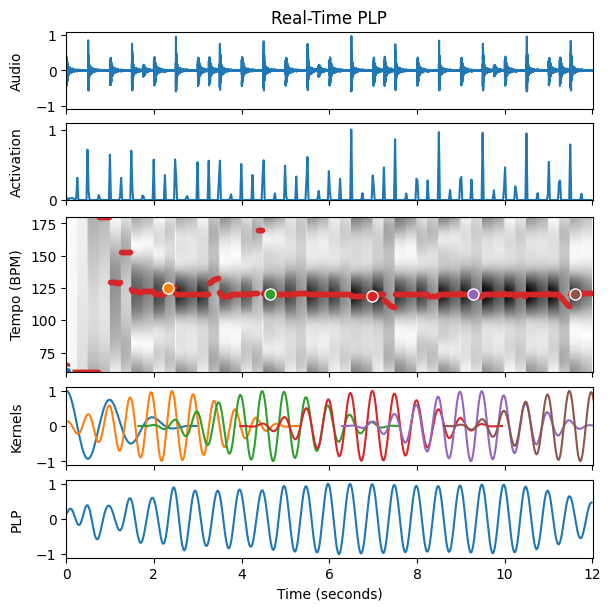

In [2]:
# FIGURE 1
mpl.rcParams["mathtext.fontset"] = "cm"

mosaic = [["A"], ["B"], ["C"], ["D"], ["E"]]
fig, axs = plt.subplot_mosaic(
    mosaic=mosaic,
    layout="constrained",
    figsize=(6, 6),
    height_ratios=(1, 1, 2, 1, 1),
    sharex=True,
)

# Waveform
axs["A"].set_title("Real-Time PLP")
waves = np.concatenate(analyzer.audio_frames)
sample_time = np.arange(len(waves)) / analyzer.tracker.activation.samplerate
axs["A"].plot(sample_time, waves)
axs["A"].set_ylim(-1.1, 1.1)
axs["A"].set_xlim(0, max(sample_time))
axs["A"].set_ylabel("Audio")

# Activation
act = np.concatenate(analyzer.activation_frames)
act /= max(act)
axs["B"].plot(analyzer.frame_times, act)
axs["B"].set_xlim(0, max(sample_time))
axs["B"].set_ylim(0, 1.1)
axs["B"].set_ylabel("Activation")

# Tempogram
tempogram = np.abs(np.hstack(analyzer.tempogram_frames))
T = analyzer.frame_times
F = analyzer.tracker.tempogram.Theta
extent = [T[0], T[-1], F[0], F[-1]]
axs["C"].imshow(tempogram, extent=extent, origin="lower", aspect="auto", cmap="Greys")
axs["C"].set_ylabel("Tempo (BPM)")
axs["C"].plot(analyzer.frame_times, analyzer.tempo_values, "C3o", markersize=3)
for i in analyzer.frame_indices[::100]:
    axs["C"].plot(
        analyzer.frame_times[i],
        analyzer.tempo_values[i],
        marker="o",
        markeredgecolor="white",
        markeredgewidth=1.0,
        markersize=8,
    )

# Kernels
for i in analyzer.frame_indices[::100]:
    kernel = analyzer.kernels[i]
    t = kernel.t + i - len(kernel.t) // 2
    t = t / analyzer.tracker.plp.framerate
    axs["D"].plot(t, kernel.x)
axs["D"].set_xlim(0, max(sample_time))
axs["D"].set_ylabel("Kernels")

# PLP
L = len(analyzer.frame_indices) + analyzer.tracker.plp.N
on_PLP = np.zeros(L)
for i, kernel in enumerate(analyzer.kernels):
    t = kernel.t + i
    on_PLP[t] = on_PLP[t] + kernel.x
on_PLP = on_PLP[analyzer.tracker.plp.N // 2 : L - analyzer.tracker.plp.N // 2]
on_PLP = on_PLP / max(on_PLP)
axs["E"].plot(analyzer.frame_times, on_PLP)
axs["E"].set_xlim(0, max(sample_time))
axs["E"].set_xlabel("Time (seconds)")
axs["E"].set_ylabel("PLP")

# Align y_labels
for ax in axs:
    axs[ax].get_yaxis().set_label_coords(-0.08, 0.5)

plt.show()

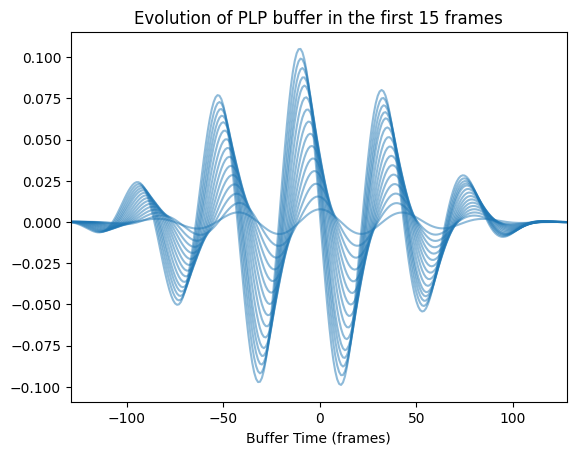

In [3]:
# FIGURE 2
fig2, axs2 = plt.subplots(1, 1)
buffer_time = np.arange(analyzer.tracker.plp.N) - analyzer.tracker.plp.N // 2
axs2.set_title("Evolution of PLP buffer in the first 15 frames")
for i in analyzer.plp_buffers[:15]:
    axs2.plot(buffer_time, i, c="C0", alpha=0.5)
axs2.set_xlim(buffer_time[0], buffer_time[-1])
axs2.set_xlabel("Buffer Time (frames)")
plt.show()

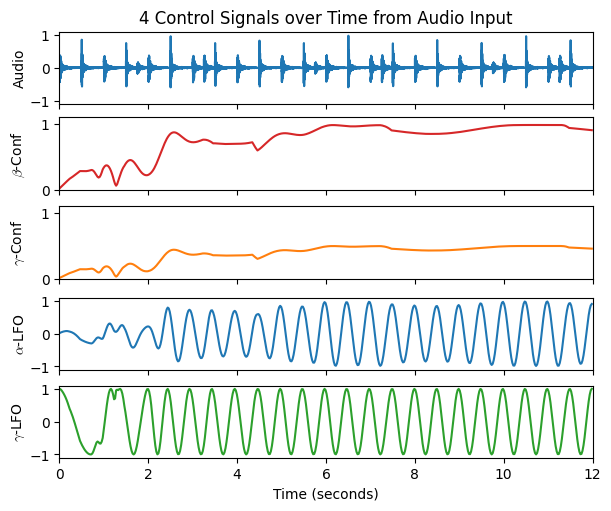

In [4]:
# FIGURE 3
fig3, axs3 = plt.subplots(
    5,
    1,
    layout="constrained",
    figsize=(6, 5),
    height_ratios=(1, 1, 1, 1, 1),
    sharex=True,
)

axs3[0].set_title("4 Control Signals over Time from Audio Input")
axs3[0].plot(sample_time, waves)
axs3[0].set_ylim(-1.1, 1.1)
axs3[0].set_xlim(0, max(sample_time))
axs3[0].set_ylabel("Audio")

axs3[1].plot(analyzer.frame_times, analyzer.beta_confs, c="C3")
axs3[1].set_ylim(0, 1.1)
axs3[1].set_xlim(0, max(analyzer.frame_times))
axs3[1].set_ylabel(r"$\beta$-Conf")

axs3[2].plot(analyzer.frame_times, analyzer.gamma_confs, c="C1")
axs3[2].set_ylim(0, 1.1)
axs3[2].set_xlim(0, max(analyzer.frame_times))
axs3[2].set_ylabel(r"$\gamma$-Conf")

axs3[3].plot(analyzer.frame_times, analyzer.alpha_lfos, c="C0")
axs3[3].set_ylim(-1.1, 1.1)
axs3[3].set_xlim(0, max(analyzer.frame_times))
axs3[3].set_ylabel(r"$\alpha$-LFO")

axs3[4].plot(analyzer.frame_times, analyzer.gamma_lfos, c="C2")
axs3[4].set_ylim(-1.1, 1.1)
axs3[4].set_xlim(0, max(analyzer.frame_times))
axs3[4].set_ylabel(r"$\gamma$-LFO")

axs3[4].set_xlabel("Time (seconds)")
axs3[4].set_xlim(0, 12)

# Align y_labels
for ax in axs3:
    ax.get_yaxis().set_label_coords(-0.06, 0.5)
plt.show()

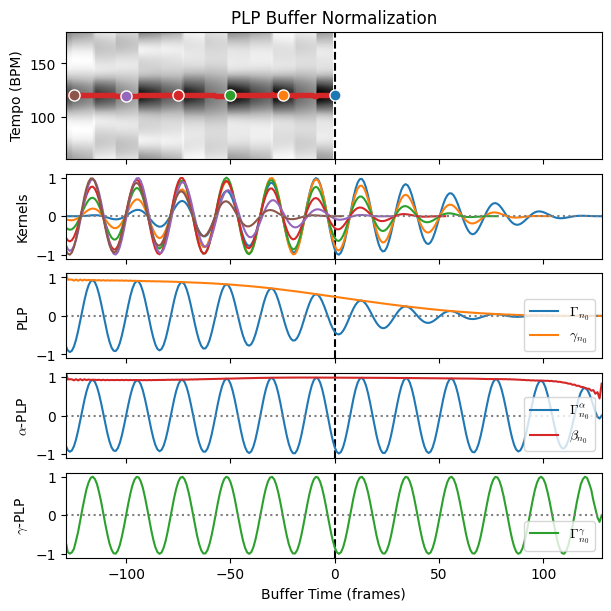

In [5]:
# FIGURE 4
fig4, axs4 = plt.subplots(
    5,
    1,
    layout="constrained",
    figsize=(6, 6),
    height_ratios=(1.5, 1, 1, 1, 1),
    sharex=True,
)

ID = 460

buffer_time = np.arange(analyzer.tracker.plp.N) - analyzer.tracker.plp.N // 2

axs4[0].set_title("PLP Buffer Normalization")
axs4[0].set_ylabel("Tempo (BPM)")
a = ID - analyzer.tracker.plp.N // 2
a = a if a >= 0 else 0
b = ID
tempogram = np.abs(np.hstack(analyzer.tempogram_frames[a:b]))
T = np.arange(tempogram.shape[1]) - tempogram.shape[1]
F = analyzer.tracker.tempogram.Theta
extent = [T[0], T[-1], F[0], F[-1]]
axs4[0].imshow(tempogram, extent=extent, origin="lower", aspect="auto", cmap="Greys")
axs4[0].plot(T, analyzer.tempo_values[a:b], "C3o", markersize=3)

axs4[1].set_ylabel("Kernels")
for i in range(ID, ID - analyzer.tracker.plp.N // 2, -25):
    kernel = analyzer.kernels[i]
    kernel_time = (kernel.t - (ID - i)) - analyzer.tracker.plp.N // 2
    if i >= 0:
        axs4[1].plot(kernel_time, kernel.x)
        axs4[0].plot(
            i - ID,
            kernel.tempo,
            marker="o",
            markeredgecolor="white",
            markeredgewidth=1.0,
            markersize=8,
        )
axs4[1].set_ylim(-1.1, 1.1)

axs4[2].set_ylabel("PLP")
axs4[2].plot(buffer_time, analyzer.plp_buffers[ID], label=r"$\Gamma_{n_0}$")
axs4[2].plot(buffer_time, analyzer.gamma_envs[ID], c="C1", label=r"$\gamma_{n_0}$")
axs4[2].set_ylim(-1.1, 1.1)
axs4[2].legend(loc=4)

axs4[3].set_ylabel(r"$\alpha$-PLP")
axs4[3].plot(buffer_time, analyzer.alpha_plps[ID], label=r"$\Gamma^{\alpha}_{n_0}$")
axs4[3].plot(buffer_time, analyzer.beta_envs[ID], c="C3", label=r"$\beta_{n_0}$")
axs4[3].set_ylim(-1.1, 1.1)
axs4[3].legend(loc=4)

axs4[4].set_ylabel(r"$\gamma$-PLP")
axs4[4].plot(
    buffer_time, analyzer.gamma_plps[ID], c="C2", label=r"$\Gamma^{\gamma}_{n_0}$"
)
axs4[4].set_ylim(-1.1, 1.1)
axs4[4].set_xlabel("Buffer Time (frames)")
axs4[4].legend(loc=4)

for ax in axs4:
    ax.set_xlim(min(buffer_time), max(buffer_time))
    ax.axvline(0, c="k", ls="--", zorder=1)

for i in [1, 2, 3, 4]:
    axs4[i].axhline(0, c="C7", ls=":")

plt.show()